## Anibis scraping

### Premable

Librairies and options

In [81]:
import pandas as pd
import numpy as np
import os
import sys
import re

from datetime import date, datetime, timedelta
import requests
from bs4 import BeautifulSoup

import matplotlib
matplotlib.rcParams.update({'font.size': 25})

## functions

In [2]:
table_header = [
    'item_id',
    'link',
    'description',
    'name',
    'price',
    'km',
    'year',
    'engine',
    'date',
    'location',
]

def get_soup(url):
    """ Get page content using 
    Beautiful soup package.
    """
    page = requests.get(url)
    if page.status_code == 200:
        # convert page content into a beautifulsoup object
        soup = BeautifulSoup(page.content, "html.parser")
    else:
        raise Exception('the page cannot be found')
    
    return soup

def get_info(row, result_dict):
    """Get info for each row"""

    item_id = int(re.search('"id":(\d+)', data_tracking).group(1))
    link = 'https://www.anibis.ch/'+row.find('a').get('href')
    description = row.find('div', {'class': 'listing-description'}).text.replace('\t', '').replace('\r', '')

    
    try:

        name = row.find('a').text.replace('\t', '').replace('\n', '').replace('\r', '')
        try:
            price = float(''.join(re.findall('\d+', row.find('div', {'class': 'listing-price'}).text)))
        except:
            price = None
        km = re.search('\d+', row.find_all('li')[0].text).group(0)
        year = re.search('\d+', row.find_all('li')[1].text).group(0)
        engine = row.find_all('li')[2].text.split(':')[1].replace(' ', '')
        date = row.find_all('li')[3].text
        location = row.find_all('li')[4].text

        result_dict['item_id'].append(item_id)
        result_dict['link'].append(link)
        result_dict['description'].append(description)
        result_dict['name'].append(name)
        result_dict['price'].append(price)
        result_dict['km'].append(km)
        result_dict['year'].append(year)
        result_dict['engine'].append(engine)
        result_dict['date'].append(date)
        result_dict['location'].append(location)
    except:
        
        
        result_dict['item_id'].append(item_id)
        result_dict['link'].append(link)
        result_dict['description'].append(description)
        result_dict['name'].append(None)
        result_dict['price'].append(None)
        result_dict['km'].append(None)
        result_dict['year'].append(None)
        result_dict['engine'].append(None)
        result_dict['date'].append(None)
        result_dict['location'].append(None)
    
    return
    

## Scraping

In [74]:
# date of scraping
path_dir = '29.06.2019'

In [75]:
if False:
    # create result dictionary
    result_dict = {k: [] for k in table_header}

    # the total number of pages is roughly 8300
    for i in range(1, 8401):

        # base url
        url = 'https://www.anibis.ch/fr/automobiles-voitures-de-tourisme--113/advertlist.aspx?pi={}'.format(i)
        
        # get page
        soup = get_soup(url)

        # loop over ads
        rows = soup.find_all('li', {'class': 'list-item listing'})
        for row in rows:
            data_tracking = row.get('data-tracking')
            get_info(row, result_dict)

        # save file every 100 pages
        # in case the loop fail and need 
        # to be rerun
        if i%100 == 0:
            print(i)
            pd.DataFrame(result_dict).set_index('item_id').to_csv('{}/{}.csv'.format(path_dir, i))
            result_dict = {k: [] for k in table_header}




In [76]:
# Regroup data into one single dataframe
df_list = []
for file in os.listdir(path_dir):
    
    if file[-3:] == 'csv':
        df_list.append(pd.read_csv(path_dir+'/'+file, index_col='item_id'))
        
df = pd.concat(df_list)
df = df.loc[df.index.drop_duplicates()]

## Transformations

Clean and transform the data.

In [77]:
name = df['name'].str.split(expand=True)

df['brand'] = name[0]
df['model'] = name[1]
df['model details'] = name[2]

df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['year'] = pd.to_datetime(df['year'].fillna(0).astype(int), format=('%Y'), errors='coerce')

df['age_car_years'] = (datetime.now()-df['year']).dt.days/365.
df['age_ad_days'] = (datetime.now()-df['date']).dt.days

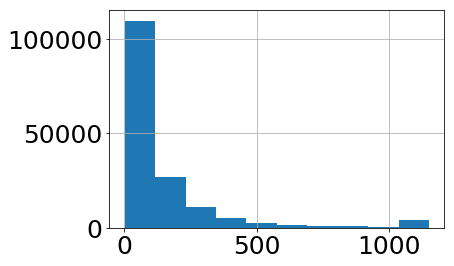

In [82]:
# Quick check
ax = df['age_ad_days'].hist()
ax.figsize = (20,10)

## Save data

In [79]:
df.to_csv(path_dir+'_all.csv')